<a href="https://colab.research.google.com/github/TRshyam/colab/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
import tarfile
%matplotlib inline

In [ ]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [ ]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 6
Label (textual): frog


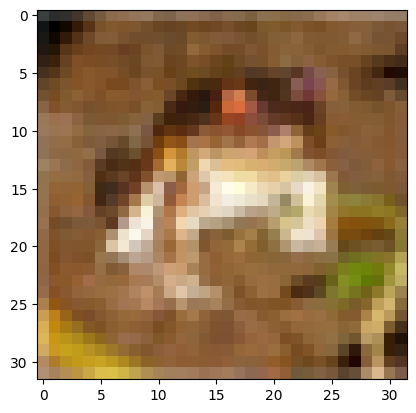

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [ ]:
torch.manual_seed(42)
val_size = 5000
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size=64

In [ ]:
train_loader = DataLoader(train_ds,
                          batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)
val_loader = DataLoader(val_ds,
                        batch_size*2,
                        num_workers=4,
                        pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size*2,
                         num_workers=4,
                         pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([64, 3, 32, 32])


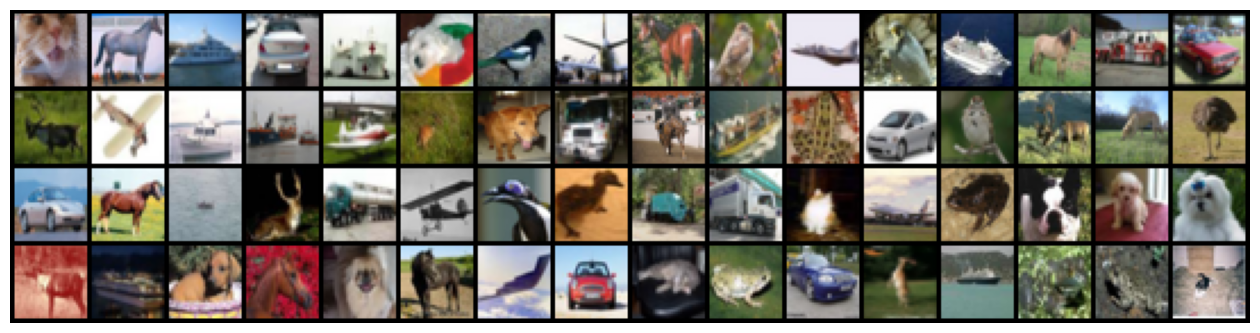

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
class char10(ImageClassificationBase):


  def __init__(self):

    super().__init__()

    self.network= nn.Sequential(

        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        # nn.Conv2d(3,32,32,kernel_size=3,stride=1,padding=1)
        # nn.ReLu()
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(512*4*4,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,10)
    )
  def forward(self,x):
    return self.network(x)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  outputs = [model.validation_step(to_device(batch, device)) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss=[]
        for batch in train_loader:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase

        result = evaluate(model, val_loader)
        result['train_loss']=torch.stack(train_loss).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True) if isinstance(data, torch.Tensor) else data

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
model=char10()

In [ ]:
train_dl=DeviceDataLoader(train_loader,device)
val_dl=DeviceDataLoader(val_loader,device)
to_device(model,device);

In [ ]:

device

device(type='cuda')

In [ ]:
# model=to_device(char10(),device)
model.to(device)

char10(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=8192, out_features=1024, bias=True)
    (15): ReLU()
    (16): Linear(in_features=1024, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, out_features=

In [ ]:
val_dl

In [ ]:
evaluate(model,val_dl)

{'val_loss': 2.3026392459869385, 'val_acc': 0.09492187201976776}

In [ ]:
history=fit(5,0.001,model,train_dl,val_dl)
history

Epoch [0], val_loss: 1.1482, val_acc: 0.5918
Epoch [1], val_loss: 0.9300, val_acc: 0.6686
Epoch [2], val_loss: 0.7939, val_acc: 0.7146
Epoch [3], val_loss: 0.7202, val_acc: 0.7525
Epoch [4], val_loss: 0.8244, val_acc: 0.7355


[{'val_loss': 1.1481720209121704,
  'val_acc': 0.591796875,
  'train_loss': 1.3681681156158447},
 {'val_loss': 0.9300298094749451,
  'val_acc': 0.6685546636581421,
  'train_loss': 1.0050737857818604},
 {'val_loss': 0.7939209342002869,
  'val_acc': 0.714648425579071,
  'train_loss': 0.7875014543533325},
 {'val_loss': 0.7201681137084961,
  'val_acc': 0.7525390386581421,
  'train_loss': 0.6277826428413391},
 {'val_loss': 0.8244119882583618,
  'val_acc': 0.735546886920929,
  'train_loss': 0.4955601394176483}]

In [ ]:
history+=fit(5,0.001,model,train_dl,val_dl)


Epoch [0], val_loss: 0.7872, val_acc: 0.7590
Epoch [1], val_loss: 0.8404, val_acc: 0.7545
Epoch [2], val_loss: 0.9344, val_acc: 0.7506
Epoch [3], val_loss: 1.0539, val_acc: 0.7559
Epoch [4], val_loss: 1.0659, val_acc: 0.7449


In [ ]:
test_loader=DeviceDataLoader(test_loader,device)
test_loader

In [ ]:
evaluate(model,test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'val_loss': 1.064548134803772, 'val_acc': 0.7393196225166321}

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

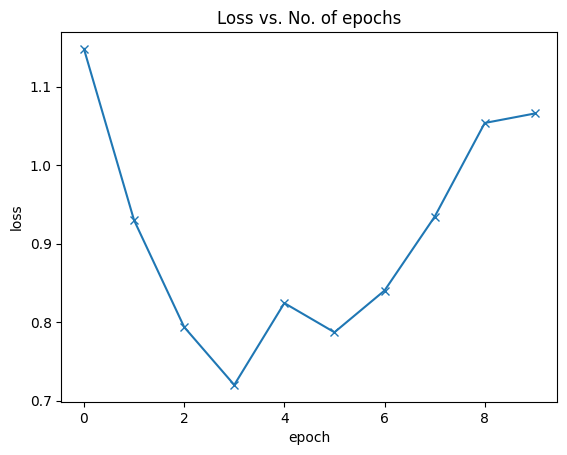

In [ ]:
plot_losses(history)

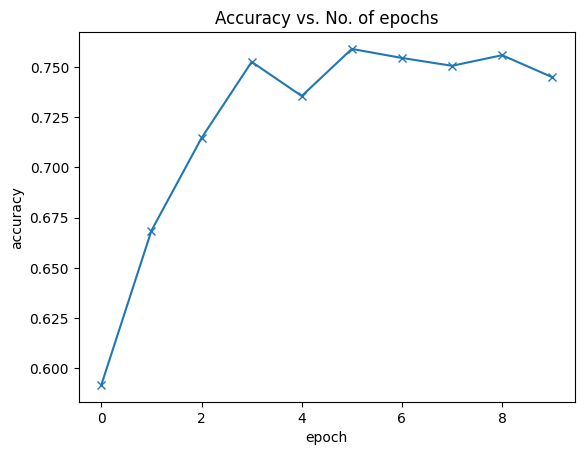

In [ ]:
plot_accuracies(history)